## Network Analysis
In this section, we will analyse the networks that we create.

In [78]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import networkx as nx
from networkx.algorithms import bipartite
import netwulf as nw

import community as community_louvain

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

In [47]:
def setup_mpl():
    mpl.rcParams['font.family'] = 'Times New Roman'
    return
setup_mpl()

In [ ]:
#load data
column_names = ['ID', 'Title', 'From', 'To', 'House', 'Term', 'Session', 'Meeting',
       'Sitting', 'Agenda', 'Subcorpus', 'Speaker_role', 'Speaker_type',
       'Speaker_party', 'Speaker_party_name', 'Party_status', 'Speaker_name',
       'Speaker_gender', 'Speaker_birth', "Text"]
ParlaMint = pd.read_csv("data/parlamint.csv", index_col=False, usecols = column_names)
ParlaMint['From'] = pd.to_datetime(ParlaMint['From'])

In [3]:
#define topic list
topic_list = ['education', 'health', 'eu', 'immigration', 'crime',
             'pandemic', 'vaccine', 'world', 'environment',
             'economy', 'legislation', 'employment', 'transport', 'tax', 'pension', 'welfare', 'defence','test']
porter = nltk.PorterStemmer()
topic_list = [porter.stem(x) for x in topic_list]

In [16]:
def preprocess(text):
    #Common english stop words
    stop_words = set(stopwords.words('english'))
    #Tokenize using nltk
    word_tokens = word_tokenize(text.lower())
    #removing none letter characters and stop words
    filtered_sentence = [w for w in word_tokens if w not in stop_words and w.isalpha()]
    #Conduct stemming
    processed_text = [porter.stem(t) for t in filtered_sentence]
    return processed_text
    
ParlaMint['tokens'] = [preprocess(x) for x in ParlaMint['Text']] 

In [4]:
ParlaMint = pd.read_csv('parlamint_preprocess.csv')
porter = nltk.PorterStemmer()
topic_list = [porter.stem(x) for x in topic_list]
import ast
ParlaMint['tokens'] = ParlaMint['tokens'].apply(lambda x: ast.literal_eval(x)) 

In [5]:
doc_pr_mp = ParlaMint.groupby('Speaker_name').tokens.sum()[1:]

### Modelling


In [13]:
BG = nx.Graph()
#Draw nodes in partitions
BG.add_nodes_from(ParlaMint.Speaker_name.unique(), bipartite=0)
BG.add_nodes_from(topic_list, bipartite=1)

In [14]:
def draw_edges(BG: nx.Graph, doc: list, mp: str, stemmed_topic_list):
    freq = dict(nltk.FreqDist([x for x in doc if x in stemmed_topic_list]))
    #Trying to make local avg_dict instead because some people may just hold more speeches
    for topic in freq.keys():
        if freq[topic] >= np.mean(list(freq.values())) + 1 * np.std(list(freq.values())):
            freq = {term: (val/(sum(freq.values()))) for (term, val) in freq.items()}
            BG.add_edge(mp, topic, weight=freq[topic])

In [15]:
for i in range(len(doc_pr_mp)):
    draw_edges(BG, doc_pr_mp.values[i], doc_pr_mp.index[i], topic_list)

In [16]:
print(f'The number of edges in the bipartite graph: {BG.number_of_edges()}')
print(f'The number of nodes in the bipartite graph: {BG.number_of_nodes()}') 

The number of edges in the bipartite graph: 3709
The number of nodes in the bipartite graph: 1913


In [17]:
for k, v in BG.nodes(data=True):
#May be an issue if one shifts party
    if k in topic_list:
        v['group'] = 'Topic'
    else:
        v['group'] = ParlaMint.loc[ParlaMint['Speaker_name']==k]["Speaker_party_name"].unique()[0]

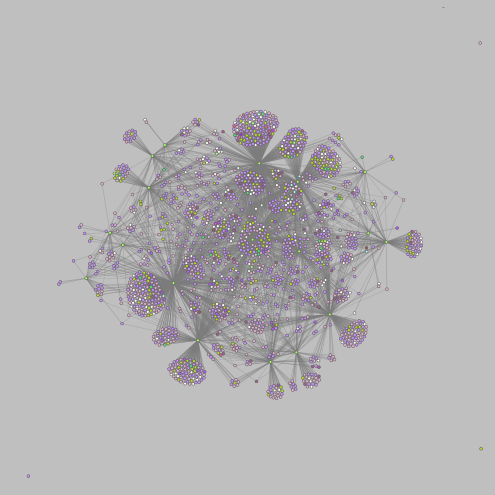

In [63]:
#Plot w/ netwulf #####SAVE PLOT######
with plt.style.context('ggplot'):
    network, config = nw.visualize(nw.get_filtered_network(BG, node_group_key='group'), plot_in_cell_below=False)
    fig, ax = nw.draw_netwulf(network) 

In [18]:
BG.remove_nodes_from(list(nx.isolates(BG)))
proj_mp = bipartite.weighted_projected_graph(BG, [x for x in doc_pr_mp.index if x in BG.nodes()]) #projected graph of mps

In [49]:
for k,node in proj_mp.nodes(data=True):
    node['group'] = sorted(BG[k].items(), key= lambda edge: edge[1]['weight'])[0][0]
    node['party'] = ParlaMint.loc[ParlaMint['Speaker_name']==k]["Speaker_party_name"].unique()[0]

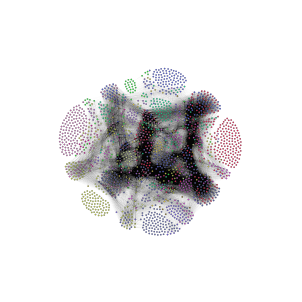

In [86]:
#plot w/ netwulf
with plt.style.context('ggplot'):
    network, config = nw.interactive.visualize(proj_mp, plot_in_cell_below=False)
    fig, ax = nw.draw_netwulf(network) 

### Graph Properties

### Community Detection
The following section will conduct community detection using the Louvain algorithm on the projected MP graph.

In [20]:
partitions = community_louvain.best_partition(proj_mp)

In [37]:
print(f'The amount of communities: {max(list(partitions.values())) + 1}')

The amount of communities: 4


Text(0.5, 1.0, 'Size of each community in projected MP network')

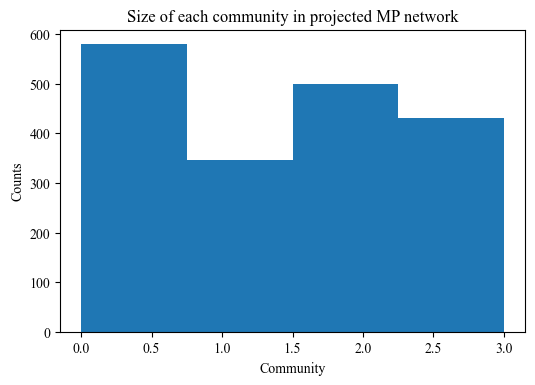

In [48]:
fig, ax = plt.subplots(dpi=100)
ax.hist(partitions.values(), bins=4)
ax.set_ylabel("Counts")
ax.set_xlabel("Community")
ax.set_title("Size of each community in projected MP network")

In [21]:
for k,node in proj_mp.nodes(data=True):
    node['detected_group'] = partitions[k]

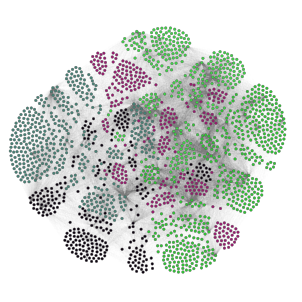

In [93]:
#Plot w/ netwulf #####SAVE PLOT######
with plt.style.context('ggplot'):
    network, config = nw.visualize(nw.get_filtered_network(proj_mp, node_group_key='detected_group'), plot_in_cell_below=False)
    fig, ax = nw.draw_netwulf(network) 

### Partition Comparison
The following section will compare the partitions obtaiend with the louvain algorithm and the partitions based on the topics.

In [22]:
from collections import Counter
######################
# Mutual Information #
######################
def get_prob(L: list)->dict:
    N = len(L)
    return {key: item/N for (key, item) in Counter(L).items()}

def entropy(px: dict)->float:
    return -sum(px[i]*np.log(px[i]) for i in px.keys())

def conditional_entropy(pxy: dict, py:dict)->float:
    return -sum(pxy[idx] * np.log(pxy[idx]/py[idx[1]]) for idx in pxy.keys())

def mutual_information(x: dict, y: dict, xy: dict, normalized=False)->float:
    if normalized:
        return (entropy(x) - conditional_entropy(xy, y))/(.5 * entropy(x) + .5 * entropy(y))
    else:
        return entropy(x) - conditional_entropy(xy, y)

In [30]:
x = [proj_mp.nodes[node]['group'] for node in proj_mp.nodes()]
y = [proj_mp.nodes[node]['detected_group'] for node in proj_mp.nodes()]
xy = [(proj_mp.nodes[node]["group"], proj_mp.nodes[node]["detected_group"]) for node in proj_mp.nodes()]
NMI = mutual_information(get_prob(x), get_prob(y), get_prob(xy), normalized=True)
NMI

0.28333684035605106

In [31]:
#Comparing with sklearn as sanity check
from sklearn.metrics import normalized_mutual_info_score
normalized_mutual_info_score(x, y)

0.2833368403560504

Randomization test

In [35]:
import random
from tqdm import tqdm
def randomize(G):
    club_dict = dict(nx.get_node_attributes(G, "club"))
    values = list(club_dict.values())
    random.shuffle(values)
    return dict(zip(G.nodes, values))

NMIs = []
for _ in tqdm(range(1001)):
    G_new = proj_mp.copy()
    node_mapping = randomize(G_new)
    nx.set_node_attributes(G_new, node_mapping, name="group")
    partition_new = community_louvain.best_partition(G_new)
    x = [G_new.nodes[node]['group'] for node in G_new.nodes()]
    y = [partition_new[node] for node in G_new.nodes()]
    xy = [(G_new.nodes[node]["group"], partition_new[node]) for node in G_new.nodes()]
    NMIs.append(mutual_information(
                            get_prob(x),
                            get_prob(y),
                            get_prob(xy),
                            normalized=True
                        )
               )

  0%|▏                                       | 4/1001 [00:44<3:05:31, 11.16s/it]


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.hist(NMIs, label="Random NMI", bins=30)
ax.axvline(NMI, linestyle='--', color='r', label="NMI")
ax.set_title("Normalized Mutual Information \n Random and  split")
ax.set_ylabel("NMI")
ax.legend()

In [50]:
#Lets see NMI between party and louvain detected communities
x2 = [proj_mp.nodes[node]['party'] for node in proj_mp.nodes()]
y2 = [proj_mp.nodes[node]['detected_group'] for node in proj_mp.nodes()]
xy2 = [(proj_mp.nodes[node]["party"], proj_mp.nodes[node]["detected_group"]) for node in proj_mp.nodes()]
NMI2 = mutual_information(get_prob(x2), get_prob(y2), get_prob(xy2), normalized=True)
NMI2

0.029865124156029144

The partition comparison yields that there is some shared information between the topic partitions and the detected communities of the Louvain algorithm($NMI\approx0.29$). However, not all the information of one partition can be described using the other partition. Consequently, an investigation of the topics within the detected louvain communities could be interesting to elucidate if any pattern emerge within the community members. A first approach is simply to compute the topic distribution within each community:

In [74]:
#Making group for each community:
communities = []
for i in range(max(list(partitions.values()))+1):
    communities.append([x for x,y in proj_mp.nodes(data=True) if y['detected_group']==i])

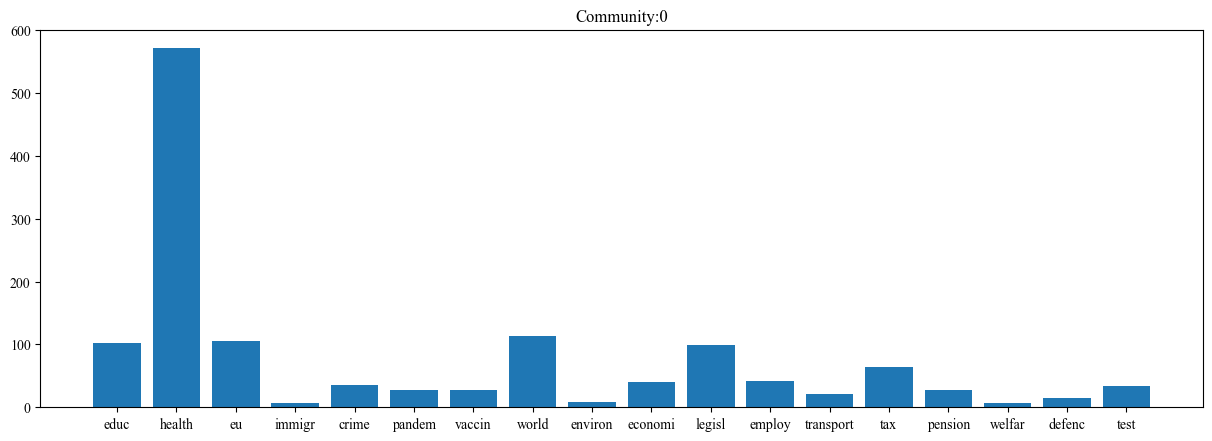

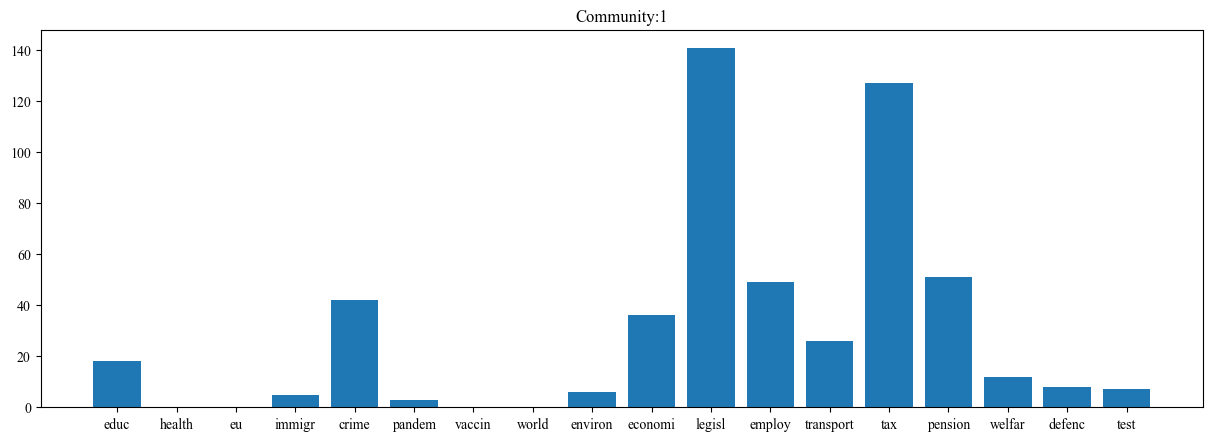

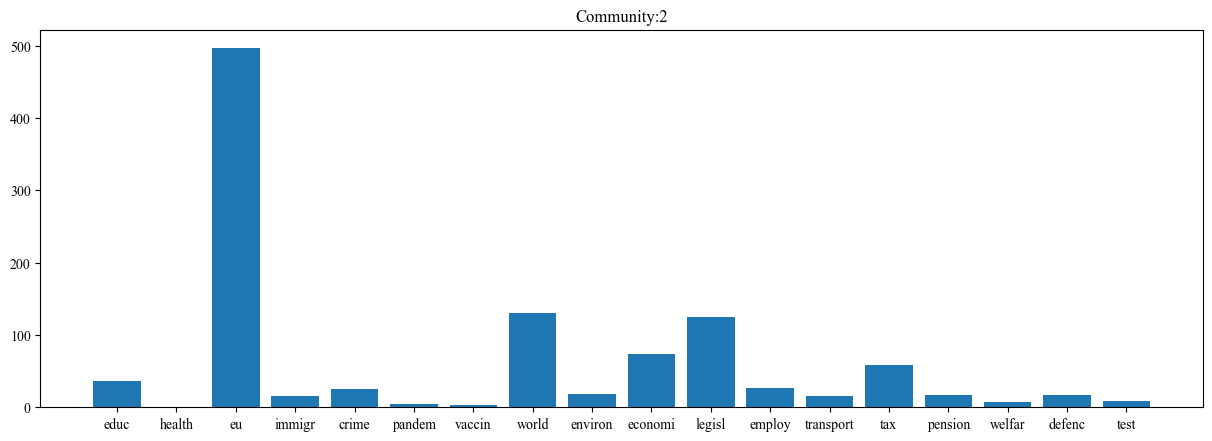

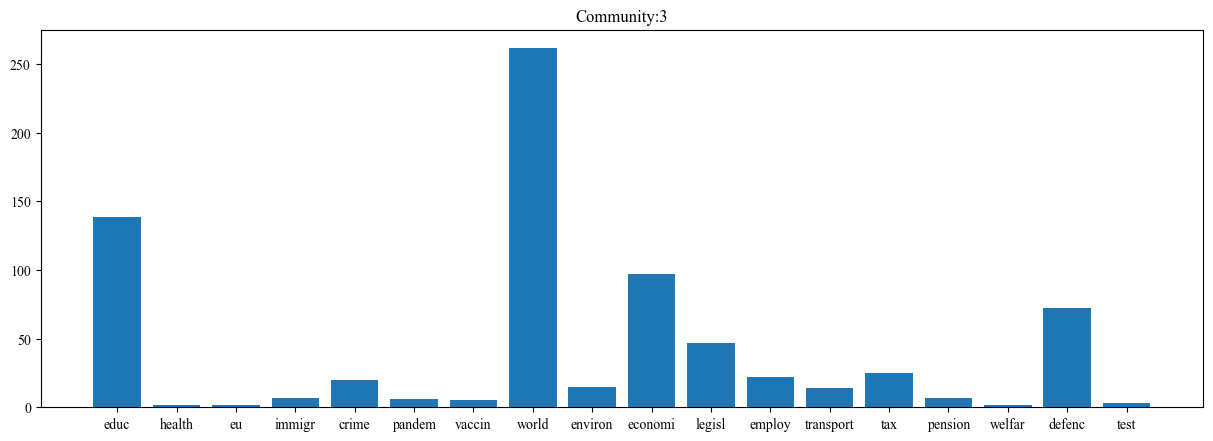

In [75]:
for i in range(max(list(partitions.values()))+1):
    topic_dist = dict.fromkeys(topic_list, 0)
    for node in communities[i]:
        for topic in BG[node].keys():
            topic_dist[topic] += 1
    fig, ax = plt.subplots(figsize=(15, 5), dpi=100)
    ax.bar(topic_dist.keys(), topic_dist.values())
    ax.set_title(f'Community: {i}')

Subsequently, TF-IDF as previously used in the text analysis section can be used to generate wordclouds related to each detected community. More specifically, the transcripts of the MPs in the same detected communities will be treated as a single document:

In [88]:
corpus_sklearn = []
stopwords = ['hon', 'nobl', 'baro', 'uk'] #Removing some domain-specific common words

for i in tqdm(range(max(list(partitions.values()))+1)):
    temp = ParlaMint[ParlaMint['Speaker_name'].isin(communities[i])]
    doc = [x for sublist in temp['tokens'] for x in sublist if x not in stopwords]
    corpus_sklearn.append(doc)

def dummy_fun(doc):
    return doc
vectorizer = TfidfVectorizer(max_df=0.9, analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)
vecs = vectorizer.fit_transform(corpus_sklearn)
feature_names = vectorizer.get_feature_names()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names).dropna()
df.index = [0,1,2,3]

100%|█████████████████████████████████████████████| 4/4 [00:23<00:00,  5.78s/it]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [92]:
#Other approach train tfidf on entire corpus with each speach being a document, and then project the grouped data afterwards
corpus_sklearn = []
for i in range(len(ParlaMint)):
    corpus_sklearn.append(ParlaMint.iloc[i,:]['tokens'])
    
def dummy_fun(doc):
    return doc
vectorizer = TfidfVectorizer(min_df=0.05, max_df=0.7, analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)
vectorizer.fit_transform(corpus_sklearn)

100%|█████████████████████████████████████████████| 4/4 [00:35<00:00,  8.86s/it]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [107]:
community_corpus = []
stopwords = ['hon', 'nobl', 'baro', 'uk', 'lord', 'peopl',
             'govern', 'amend', 'minist', 'member', 'friend',
             'need', 'would', 'work', 'hous', 'make', 'bill',
             'one', 'right', 'year', 'also', 'debat', 'us',
             'time', 'support', 'issu', 'say', 'said', 'mani',
             'made', 'take','provid', 'want', 'new', 'point', 'think']
for i in tqdm(range(max(list(partitions.values()))+1)):
    temp = ParlaMint[ParlaMint['Speaker_name'].isin(communities[i])]
    doc = [x for sublist in temp['tokens'] for x in sublist if x not in stopwords]
    community_corpus.append(doc)
vecs = vectorizer.transform(community_corpus)
feature_names = vectorizer.get_feature_names()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names).dropna()
df.index = [0,1,2,3]

100%|█████████████████████████████████████████████| 4/4 [01:06<00:00, 16.72s/it]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


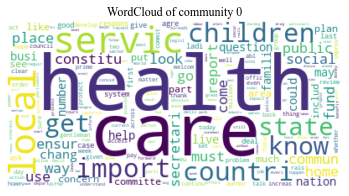

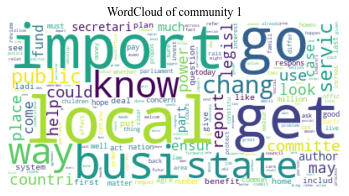

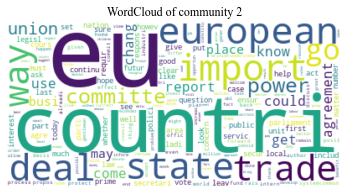

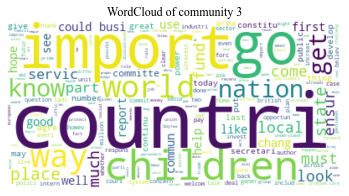

In [109]:
for i in range(len(df)):
    Cloud = WordCloud(background_color='white').generate_from_frequencies(df.iloc[i,:])
    plt.imshow(Cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud of community {df.index[i]}')
    plt.savefig(f'clouds/wordcloud_{df.index[i]}.pdf', dpi = 200)
    plt.show()

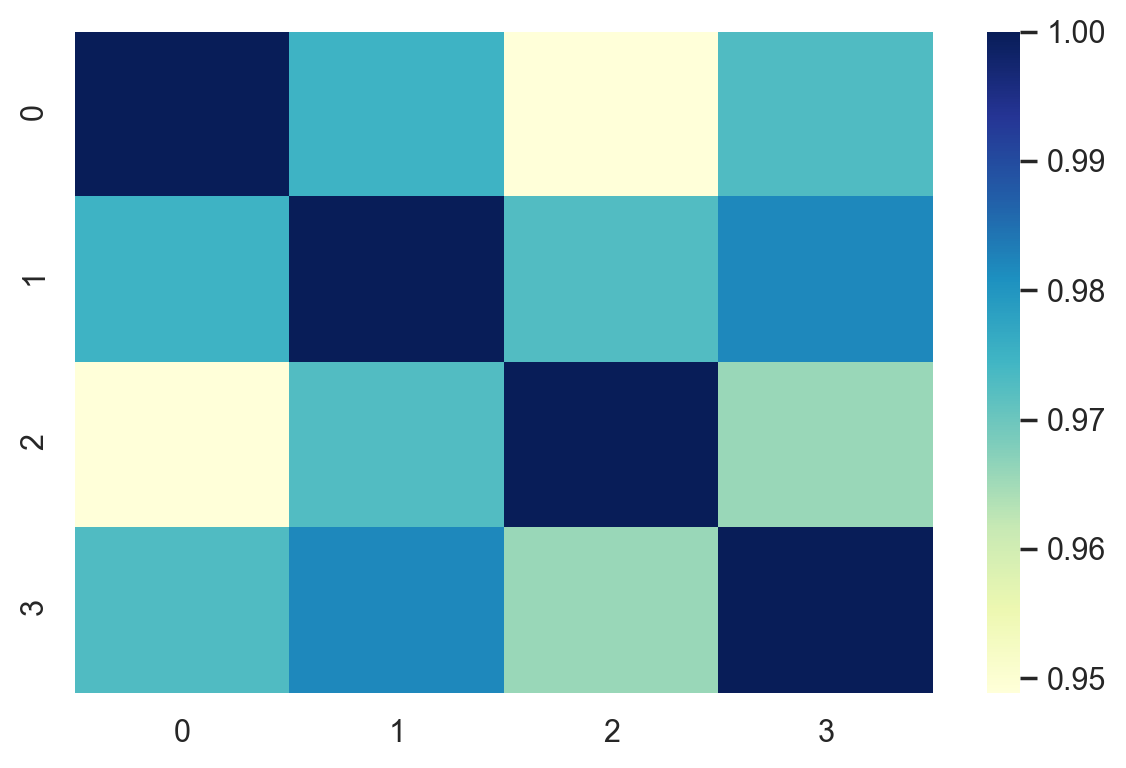

In [110]:
import seaborn as sns; sns.set_theme()
sim_matrix = (df.to_numpy() @ df.to_numpy().T)
fig, ax = plt.subplots(dpi=200)
sns.heatmap(sim_matrix, xticklabels=[0,1,2,3] ,yticklabels=[0,1,2,3], cmap="YlGnBu")
plt.tight_layout()